In [1]:
import math
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from my_ecog_utils import read_with_annotations, get_multitaper_power_bands

In [2]:
pts_w_any_stim = [100, 103, 105, 106, 109, 110, 111, 112, 113, 115, 202]
freqs = ['Delta', 'Theta', 'Alpha', 'Beta', 'GammaLow', 'GammaMed', 'GammaHigh', 'GammaXHigh']

results_before_after = pd.DataFrame(columns=['ID', 'Stim', 'Trial', 'Channel', 'Delta', 'Theta', 'Alpha', 'Beta'])
results_before_after.loc[:,'Stim'] = results_before_after['Stim'].astype('bool')

for pt_num in pts_w_any_stim:
    raw = read_with_annotations(pt_num, annotations='every_pre')
    if pt_num in [100, 103, 112, 115]:
        raw.load_data()
        raw.notch_filter(62.5)

    try:
        evts, event_id = mne.events_from_annotations(raw, {'BAD_': 0, 'post_shock': 2, 'pre_shock': 1})
        epochs = mne.Epochs(raw, evts, event_id=event_id, tmin=0, tmax=1, baseline=(0.5,1.0))
    except:
        print(evts)
        raise Exception()

    if pt_num == 100:
        epochs.rename_channels({'Hip1 - Hip2': 'LHip1 - LHip2', 'Hip3 - Hip4': 'LHip3 - LHip4'})
    elif pt_num == 113:
        epochs.rename_channels(lambda s: s.replace('H', 'Hip'))

    # drop segments that overlap with shocks
    # i.e. those that are shorter than 1 second. May change tmax in the future
    epochs.drop_bad()
    
    # if you ever need to debug, look at the drop logs
    print(epochs.drop_log)
    trial_num = 0
    last_trial_time = -31
    epoch_num = 0
    shock_num = 1
    for i in range(len(epochs.drop_log)):
        epoch = epochs[epoch_num]
        shock_num += 1
        if epochs.drop_log[i] == ('BAD_',):
            continue
        is_post_stim = 'post_shock' in epoch.event_id
        # trials are usually 20-30 sec long
        if not is_post_stim and evts[:,0][i] - last_trial_time > 30 * epochs.info['sfreq']:
            trial_num += 1
            shock_num = 0
            last_trial_time = evts[:,0][i]
        for chan in epochs.ch_names:
            powers = get_multitaper_power_bands(epoch, picks=chan, split_gamma=True)
            results_before_after = results_before_after.append({'ID': pt_num, 'Stim': is_post_stim, 'Trial': trial_num, 'Channel': chan, 'Stim_Num': shock_num, **powers}, ignore_index=True)
        epoch_num += 1

results_before_after.to_csv('each_stim_before_after.csv', index=False)
results_before_after

Opening raw data file data/100/stimulated_ieeg.fif...
Isotrak not found
    Range : 0 ... 51647 =      0.000 ...   206.588 secs
Ready.
Reading 0 ... 51647  =      0.000 ...   206.588 secs...
Setting up band-stop filter from 62 - 63 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.84
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 61.59 Hz)
- Upper passband edge: 63.16 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.41 Hz)
- Filter length: 1651 samples (6.604 sec)

Used Annotations descriptions: ['post_shock', 'pre_shock']
Not setting metadata
Not setting metadata
24 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 24 events and 251 original time points ...
0 bad epochs dropped
((), (),

ID   Stim Trial        Channel         Delta         Theta  \
0    100  False     1  LHip1 - LHip2  7.676245e-08  7.966128e-08   
1    100  False     1  LHip3 - LHip4  7.599882e-08  5.435899e-08   
2    100  False     1  LatT1 - LatT2  1.777491e-09  1.945915e-09   
3    100  False     1  LatT3 - LatT4  1.063224e-08  1.579306e-08   
4    100   True     1  LHip1 - LHip2  1.142425e-07  7.161263e-08   
..   ...    ...   ...            ...           ...           ...   
995  202  False     3    LHT3 - LHT4  1.277433e-08  1.928902e-09   
996  202   True     3    LOT1 - LOT2  1.898780e-08  4.586229e-09   
997  202   True     3    LOT3 - LOT4  8.277882e-09  4.419796e-09   
998  202   True     3    LHT1 - LHT2  3.353753e-09  1.279668e-09   
999  202   True     3    LHT3 - LHT4  1.437498e-08  1.089688e-09   

            Alpha          Beta     GammaHigh      GammaLow      GammaMed  \
0    3.897899e-08  1.350653e-08  1.342159e-10  1.014126e-09  2.448737e-10   
1    7.955522e-09  3.615457e-09  5.158829e-11  8.472699e-10  8.771663e-11   
2    7.836614e-10  2.448647e-10  1.145110e-11  5.035184e-11  1.546049e-11   
3    8.962653e-09  1.447087e-09  2.411582e-11  2.195220e-10  4.948296e-11   
4    2.537439e-08  1.169223e-08  9.841945e-11  9.902345e-10  3.155199e-10   
..            ...           ...           ...           ...           ...   
995  9.470874e-10  5.094657e-10  1.314259e-11  3.114832e-11  1.671893e-11   
996  3.352016e-09  2.677703e-09  2.795191e-11  3.338441e-10  9.118730e-11   
997  5.411698e-09  2.388939e-09  2.591528e-11  1.987887e-10  9.733117e-11   
998  7.131607e-10  4.481172e-10  1.177992e-11  9.922757e-11  2.966367e-11   
999  8.153352e-10  3.662438e-10  9.421769e-12  5.989246e-11  1.964661e-11   

       GammaXHigh  Stim_Num  
0    3.160809e-11       0.0  
1    2.150510e-11       0.0  
2    7.259526e-12       0.0  
3    2.017395e-11       0.0  
4    4.089712e-11       1.0  
..            ...       ...  
995  6.175326e-12       9.0  
996  1.372056e-11      11.0  
997  1.321946e-11      11.0  
998  1.306017e-11      11.0  
999  5.984564e-12      11.0  

[1000 rows x 13 columns]

In [3]:
results_before_after['Stim_Num'] = results_before_after['Stim_Num'] // 2

In [4]:
results_before_after['Stim_Num'] = results_before_after['Stim_Num'].astype(int)

baselines = results_before_after[results_before_after['Stim'] == False]
stims = results_before_after[results_before_after['Stim'] == True]
rearranged = stims.merge(baselines, on=['ID', 'Trial', 'Channel', 'Stim_Num'], suffixes=['_post', '_pre'])
rearranged = rearranged.drop(['Stim_post', 'Stim_pre'], axis='columns')

In [5]:
power_log_chg = rearranged.copy()
for freq in freqs:
    power_log_chg[freq+'_log_chg'] = np.log10(rearranged[freq+'_post']) - np.log10(rearranged[freq+'_pre'])
# power_log_chg = power_log_chg.drop('Stim_Num_pre', axis=1).rename({'Stim_Num_post': 'Stim_Num'}, axis=1)
power_log_chg

ID Trial        Channel    Delta_post    Theta_post    Alpha_post  \
0    100     1  LHip1 - LHip2  1.142425e-07  7.161263e-08  2.537439e-08   
1    100     1  LHip3 - LHip4  3.784396e-07  7.526684e-08  5.945997e-09   
2    100     1  LatT1 - LatT2  1.378031e-09  2.185936e-09  1.179630e-09   
3    100     1  LatT3 - LatT4  8.129781e-08  7.790410e-09  4.389105e-09   
4    100     1  LHip1 - LHip2  5.835947e-08  3.228662e-08  2.086371e-08   
..   ...   ...            ...           ...           ...           ...   
463  202     3    LHT3 - LHT4  1.140535e-08  1.126939e-09  8.131701e-10   
464  202     3    LOT1 - LOT2  3.550790e-08  1.153714e-08  2.278720e-09   
465  202     3    LOT3 - LOT4  9.146609e-09  6.811802e-09  3.374165e-09   
466  202     3    LHT1 - LHT2  1.318418e-09  1.206045e-09  9.419762e-10   
467  202     3    LHT3 - LHT4  1.042007e-08  8.687519e-10  1.712772e-09   

        Beta_post  GammaHigh_post  GammaLow_post  GammaMed_post  ...  \
0    1.169223e-08    9.841945e-11   9.902345e-10   3.155199e-10  ...   
1    3.396220e-09    8.039247e-11   8.468632e-10   1.507339e-10  ...   
2    2.098490e-10    1.228712e-11   4.416371e-11   1.970511e-11  ...   
3    1.734181e-09    3.738994e-11   2.994732e-10   5.937977e-11  ...   
4    8.328850e-09    1.467862e-10   1.225056e-09   2.848021e-10  ...   
..            ...             ...            ...            ...  ...   
463  4.845502e-10    1.317265e-11   6.965751e-11   2.003857e-11  ...   
464  2.943730e-09    2.888773e-11   3.305943e-10   1.487729e-10  ...   
465  2.080614e-09    4.543147e-11   1.954827e-10   4.527764e-11  ...   
466  6.011702e-10    1.193692e-11   6.070554e-11   2.430652e-11  ...   
467  5.998392e-10    1.263479e-11   4.582474e-11   1.437073e-11  ...   

     GammaMed_pre  GammaXHigh_pre  Delta_log_chg  Theta_log_chg  \
0    2.448737e-10    3.160809e-11       0.172679      -0.046258   
1    8.771663e-11    2.150510e-11       0.697190       0.141332   
2    1.546049e-11    7.259526e-12      -0.110548       0.050514   
3    4.948296e-11    2.017395e-11       0.883454      -0.306906   
4    5.778968e-10    4.162106e-11       0.439985       0.037215   
..            ...             ...            ...            ...   
463  1.637252e-11    5.560495e-12       1.150877      -0.177714   
464  6.489303e-11    1.398333e-11       0.362258      -0.006381   
465  7.123105e-11    9.480527e-12       0.065842       0.045289   
466  2.610208e-11    8.207254e-12      -0.117596      -0.105110   
467  1.963331e-11    6.364368e-12       0.564010      -0.530514   

     Alpha_log_chg  Beta_log_chg  GammaLow_log_chg  GammaMed_log_chg  \
0        -0.186435     -0.062647         -0.010354          0.110085   
1        -0.126444     -0.027167         -0.000208          0.235129   
2         0.177617     -0.067019         -0.056950          0.105356   
3        -0.310061      0.078600          0.134880          0.079183   
4        -0.182963      0.020740         -0.115489         -0.307307   
..             ...           ...               ...               ...   
463      -0.516221     -0.195618          0.244322          0.087751   
464      -0.222434      0.229174          0.100273          0.360326   
465       0.021033      0.059923         -0.012712         -0.196786   
466       0.172754     -0.064298         -0.152160         -0.030952   
467       0.166849      0.232527          0.016653         -0.135515   

     GammaHigh_log_chg  GammaXHigh_log_chg  
0            -0.134723            0.111894  
1             0.192664            0.121860  
2             0.030603            0.082202  
3             0.190453            0.049423  
4             0.136379           -0.060573  
..                 ...                 ...  
463           0.143097            0.049284  
464           0.100764           -0.153230  
465           0.191675           -0.154657  
466          -0.088260           -0.057565  
467           0.078629            0.091936  

[468 rows x 28 columns]

In [6]:
power_log_chg.to_csv('pre_post_stim.csv', index=False)

Does Pre-Stim Power predict Change in Power?

Delta LHip1 - LHip2: t = -9.02, p = 1.811540280395585e-19
Delta LHip3 - LHip4: t = -9.38, p = 6.846846738063644e-21
Delta RHip1 - RHip2: t = -8.10, p = 5.30649527282728e-16
Delta RHip3 - RHip4: t = -8.25, p = 1.5769289407277385e-16
Theta LHip1 - LHip2: t = -9.15, p = 5.503258750763664e-20
Theta LHip3 - LHip4: t = -8.93, p = 4.187753599693772e-19
Theta RHip1 - RHip2: t = -5.82, p = 5.848311622681827e-09
Theta RHip3 - RHip4: t = -6.71, p = 1.9021984730064352e-11
Alpha LHip1 - LHip2: t = -8.48, p = 2.3281171662259518e-17
Alpha LHip3 - LHip4: t = -7.47, p = 8.197990656727893e-14
Alpha RHip1 - RHip2: t = -4.93, p = 8.404325895807465e-07
Alpha RHip3 - RHip4: t = -6.60, p = 4.1523442327153996e-11
Beta LHip1 - LHip2: t = -8.16, p = 3.301034864029167e-16
Beta LHip3 - LHip4: t = -8.18, p = 2.7396270229715785e-16
Beta RHip1 - RHip2: t = -4.13, p = 3.6036154312493426e-05
Beta RHip3 - RHip4: t = -3.17, p = 0.0015493609216681737
GammaLow LHip1 - LHip2: t = -5.71, p = 1.1238023191727924e-08
GammaLow 

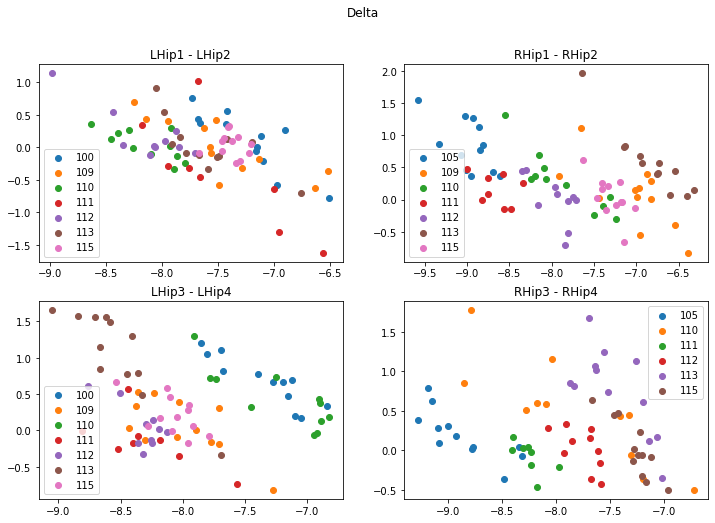

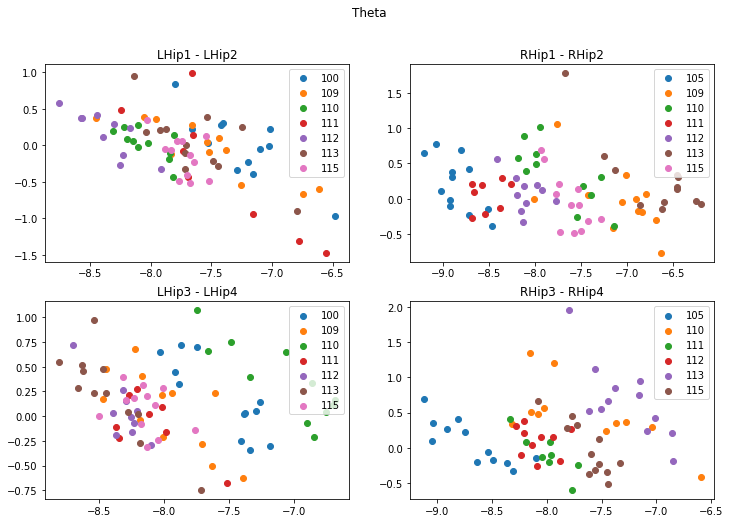

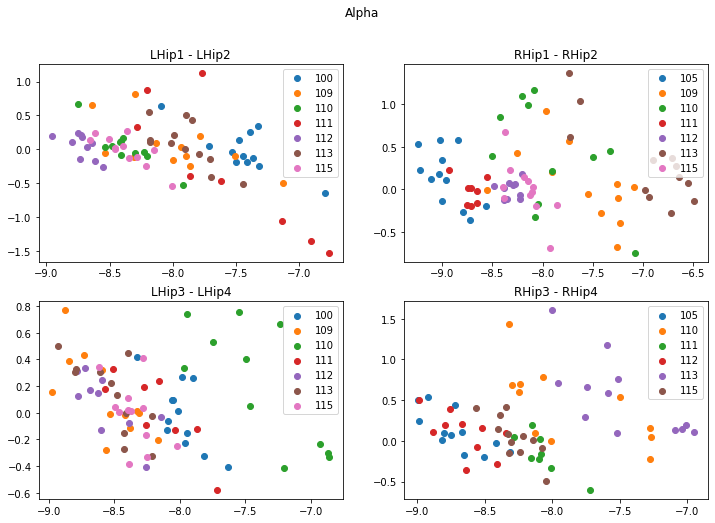

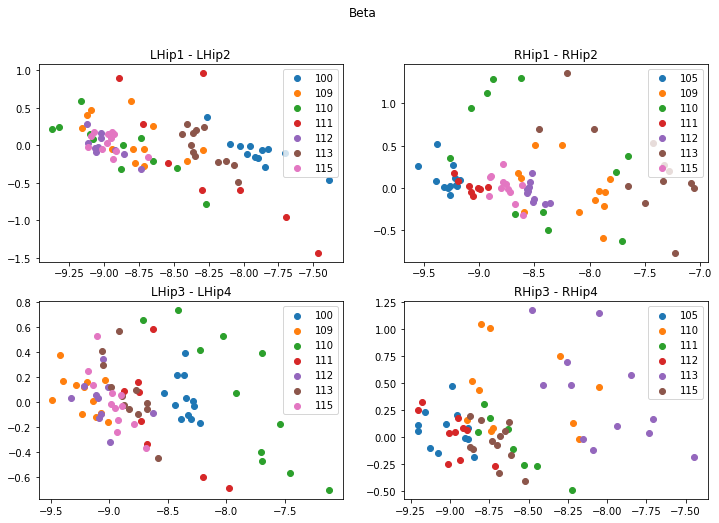

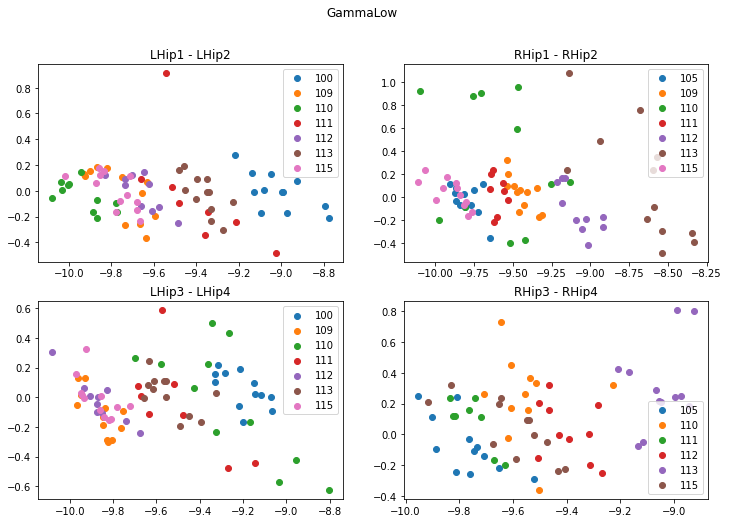

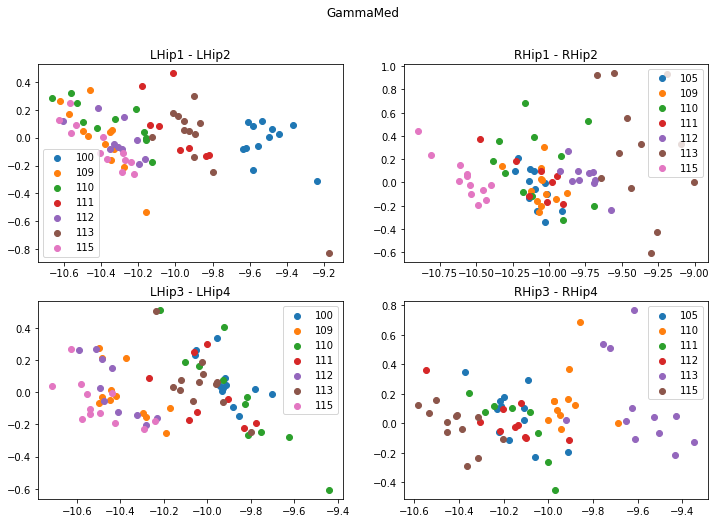

In [7]:
import statsmodels.formula.api as smf
from IPython.display import display

freqs = ['Delta', 'Theta', 'Alpha', 'Beta', 'GammaLow', 'GammaMed']
stim_stats = []
for freq in freqs:
    hip_chans = ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']
    fig, axs = plt.subplots(2, 2)
    fig.set_size_inches(12, 8)
    fig.suptitle(freq)
    for ch_num, chan in enumerate(hip_chans):
        power_for_chan = power_log_chg[(power_log_chg['Channel'] == chan)]
        ax = axs[ch_num % 2, ch_num // 2]
        for i, pt in enumerate(power_for_chan['ID'].unique()):
            power_for_pt = power_for_chan[power_for_chan['ID'] == pt]
            ax.scatter(np.log10(power_for_pt[freq+'_pre']), power_for_pt[freq+'_log_chg'], label=pt)
            ax.legend()
            ax.set_title(chan)
        model = smf.mixedlm(f'{freq}_log_chg ~ np.log10({freq}_pre)', power_for_chan, groups=power_for_chan['ID'])
        results = model.fit()
        # 0th value is for intercept, 1th is for $FREQ_pre
        print(f"{freq} {chan}: t = {results.tvalues[1]:.2f}, p = {results.pvalues[1]}")
        stim_stats.append({
            'freq': freq, 'chan': chan,
            't': results.tvalues[1], 'p': results.pvalues[1], 'coeff': results.params[1], 'int': results.params[0]})

The answer is definitely yes, pre-stim power predicts change in power. We saw with the parametric tests earlier that there is no pattern whereby stimulation routinely increases or decreases power in a channel/frequency across all patients. However, the mixed-model regression definitely shows us that there is a negative correlation between the pre-stim power and the change in power. This suggests that whenever the brain is stimulated, the power is reset, possibly depending on the amount of current added. If there was too much current before stimulation, then stim will interrupt that and set a lower level, but if there was too little current before stimulation, then stim will add power to the circuit.

How can we be sure that this isn't just regression to the mean/test-retest effect?

One way to do it is to graph Post-stim power against Pre-stim power. If the Post-stim power is always around the same level regardless of what the pre-stim power was, then this supports the hypothesis that stimulation resets power. If our correlation was just an artifact of test-retest effect, then ... idk actually.

Delta LHip1 - LHip2: t = 2.01, p = 0.04471279891467097
Delta LHip3 - LHip4: t = 1.03, p = 0.3009139334100117
Delta RHip1 - RHip2: t = 1.15, p = 0.25202246144557094
Delta RHip3 - RHip4: t = 1.29, p = 0.19719624475644182
Theta LHip1 - LHip2: t = 1.19, p = 0.23358437271867127
Theta LHip3 - LHip4: t = 1.12, p = 0.26459321132570124
Theta RHip1 - RHip2: t = 2.19, p = 0.028539597720326413
Theta RHip3 - RHip4: t = 1.85, p = 0.06379678089534446
Alpha LHip1 - LHip2: t = 0.38, p = 0.7064669002979984
Alpha LHip3 - LHip4: t = 2.09, p = 0.036582654212102175
Alpha RHip1 - RHip2: t = 3.06, p = 0.0022216851453931608
Alpha RHip3 - RHip4: t = 1.71, p = 0.08745627795937896
Beta LHip1 - LHip2: t = 0.40, p = 0.6926727232534049
Beta LHip3 - LHip4: t = 1.08, p = 0.27890860952403984
Beta RHip1 - RHip2: t = 3.37, p = 0.0007524832366338135
Beta RHip3 - RHip4: t = 2.77, p = 0.005583698805616273
GammaLow LHip1 - LHip2: t = 0.43, p = 0.6659710644889569
GammaLow LHip3 - LHip4: t = -0.20, p = 0.8404037634543617
Gamma

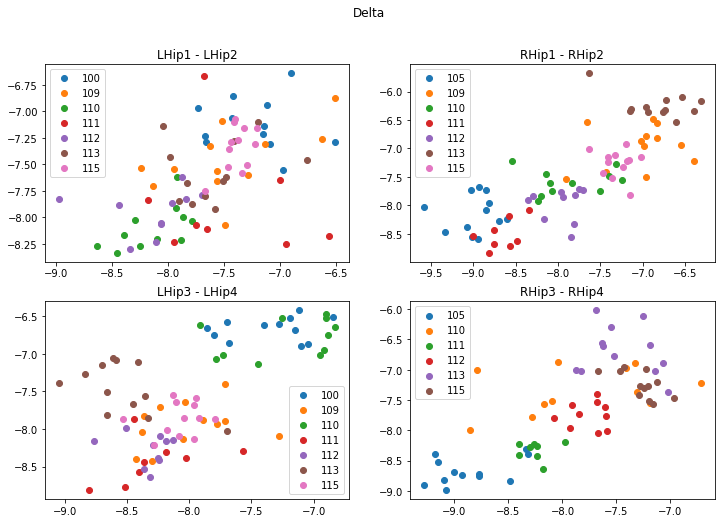

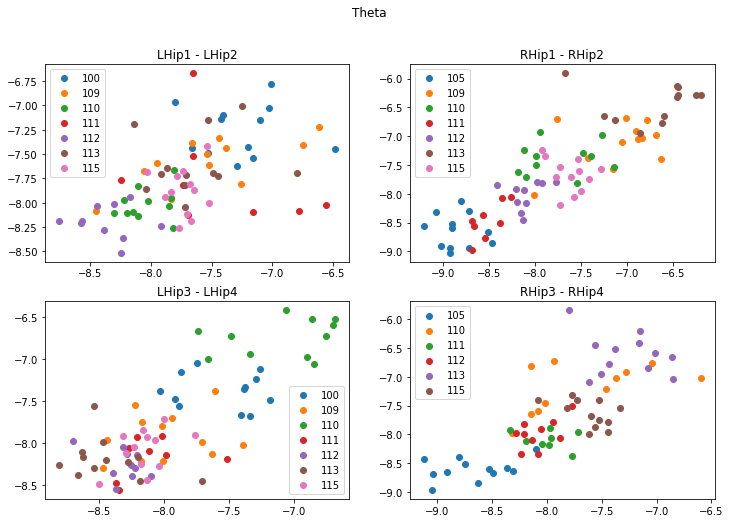

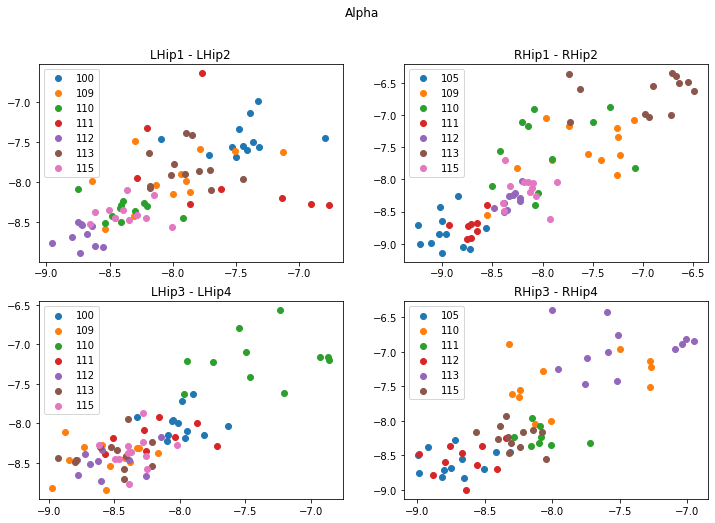

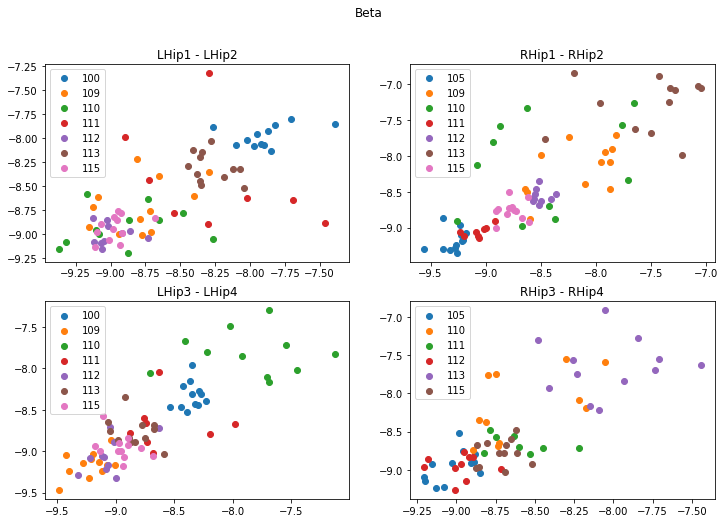

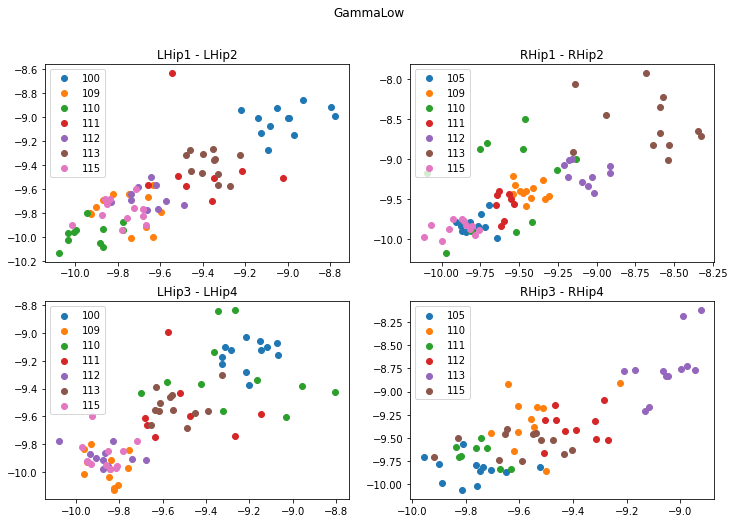

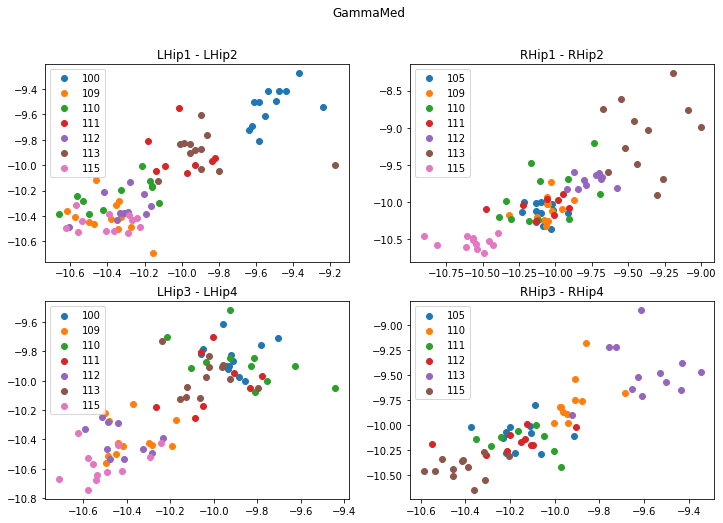

In [8]:
import statsmodels.formula.api as smf
from IPython.display import display

freqs = ['Delta', 'Theta', 'Alpha', 'Beta', 'GammaLow', 'GammaMed']
for freq in freqs:
    hip_chans = ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']
    fig, axs = plt.subplots(2, 2)
    fig.set_size_inches(12, 8)
    fig.suptitle(freq)
    for ch_num, chan in enumerate(hip_chans):
        power_for_chan = power_log_chg[(power_log_chg['Channel'] == chan)]
        ax = axs[ch_num % 2, ch_num // 2]
        for i, pt in enumerate(power_for_chan['ID'].unique()):
            power_for_pt = power_for_chan[power_for_chan['ID'] == pt]
            ax.scatter(np.log10(power_for_pt[freq+'_pre']), np.log10(power_for_pt[freq+'_post']), label=pt)
            ax.legend()
            ax.set_title(chan)
        model = smf.mixedlm(f'np.log10({freq}_post) ~ np.log10({freq}_pre)', power_for_chan, groups=power_for_chan['ID'])
        results = model.fit()
        # 0th value is for intercept, 1th is for $FREQ_pre
        print(f"{freq} {chan}: t = {results.tvalues[1]:.2f}, p = {results.pvalues[1]}")

I found a research paper showing how to quantify the expected effect of regression to the mean. If these equations don't work, we can also try using the control data to make a sham dataset

In [9]:
power_for_chan = power_log_chg[(power_log_chg['Channel'] == 'LHip3 - LHip4')]
model = smf.mixedlm(f'Delta_log_chg ~ np.log10(Delta_pre)', power_for_chan, groups=power_for_chan['ID'])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:             MixedLM  Dependent Variable:  Delta_log_chg
No. Observations:  77       Method:              REML         
No. Groups:        7        Scale:               0.0663       
Min. group size:   8        Log-Likelihood:      -20.5894     
Max. group size:   12       Converged:           Yes          
Mean group size:   11.0                                       
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           -6.841    0.805 -8.500 0.000 -8.419 -5.264
np.log10(Delta_pre) -0.901    0.096 -9.376 0.000 -1.089 -0.712
Group Var            0.422    1.022                           
==============================================================

"""

Nvm I have no idea how to get the values I need for their equation. Time to make a sham dataset

In [10]:
pts_w_control_and_stim = [103, 106, 109, 110, 111, 112, 113, 115]
freqs = ['Delta', 'Theta', 'Alpha', 'Beta', 'GammaLow', 'GammaMed', 'GammaHigh', 'GammaXHigh']

results_before_after = pd.DataFrame(columns=['ID', 'Stim', 'Trial', 'Channel', 'Delta', 'Theta', 'Alpha', 'Beta'])
results_before_after.loc[:,'Stim'] = results_before_after['Stim'].astype('bool')

for pt_num in pts_w_control_and_stim:
    raw = read_with_annotations(pt_num, stim='control', annotations='dummy')
    if pt_num in [100, 103, 112, 115]:
        raw.load_data()
        raw.notch_filter(62.5)

    try:
        evts, event_id = mne.events_from_annotations(raw, {'BAD_': 0, 'post_shock': 2, 'pre_shock': 1})
        epochs = mne.Epochs(raw, evts, event_id=event_id, tmin=0, tmax=1, baseline=(0.5,1.0))
    except:
        # pt 103 has too short of a control recording, so there aren't actually any events
        continue

    if pt_num == 100:
        epochs.rename_channels({'Hip1 - Hip2': 'LHip1 - LHip2', 'Hip3 - Hip4': 'LHip3 - LHip4'})
    elif pt_num == 113:
        epochs.rename_channels(lambda s: s.replace('H', 'Hip'))

    # drop segments that overlap with shocks
    # i.e. those that are shorter than 1 second. May change tmax in the future
    epochs.drop_bad()
    
    # if you ever need to debug, look at the drop logs
    print(epochs.drop_log)
    trial_num = 0
    last_trial_time = -31
    epoch_num = 0
    shock_num = 1
    for i in range(len(epochs.drop_log)):
        # epochs that are not dropped have an empty tuuple in the drop log
        if epochs.drop_log[i] != ():
            continue
        shock_num += 1
        epoch = epochs[epoch_num]
        is_post_stim = 'post_shock' in epoch.event_id
        # trials are usually 20-30 sec long
        if not is_post_stim and evts[:,0][i] - last_trial_time > 30 * epochs.info['sfreq']:
            trial_num += 1
            shock_num = 0
            last_trial_time = evts[:,0][i]
        for chan in epochs.ch_names:
            powers = get_multitaper_power_bands(epoch, picks=chan, split_gamma=True)
            results_before_after = results_before_after.append({'ID': pt_num, 'Stim': is_post_stim, 'Trial': trial_num, 'Channel': chan, 'Stim_Num': shock_num, **powers}, ignore_index=True)
        epoch_num += 1

results_before_after.to_csv('each_stim_before_after.csv', index=False)
results_before_after

Opening raw data file data/103/control_ieeg.fif...
Isotrak not found
    Range : 0 ... 6551 =      0.000 ...    26.204 secs
Ready.
Reading 0 ... 6551  =      0.000 ...    26.204 secs...
Setting up band-stop filter from 62 - 63 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.84
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 61.59 Hz)
- Upper passband edge: 63.16 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.41 Hz)
- Filter length: 1651 samples (6.604 sec)

Opening raw data file data/106/control_ieeg.fif...
Isotrak not found
    Range : 0 ... 59999 =      0.000 ...   239.996 secs
Ready.
Used Annotations descriptions: ['post_shock', 'pre_shock']
Not setting metadata
Not setting metadata
21 matching events found
Applying baseline correction (mod

ID   Stim Trial        Channel         Delta         Theta  \
0    106  False     1    lps1 - lps2  2.092556e-10  4.103496e-10   
1    106  False     1    lps3 - lps4  1.713966e-09  1.679099e-09   
2    106  False     1  lpih1 - lpih2  4.636241e-09  6.334603e-09   
3    106  False     1  lpih3 - lpih4  2.916347e-10  5.968850e-10   
4    106   True     1    lps1 - lps2  4.008490e-10  8.906447e-10   
..   ...    ...   ...            ...           ...           ...   
543  115  False     3  RHip3 - RHip4  5.279521e-08  3.718544e-08   
544  115   True     3  LHip1 - LHip2  3.690138e-08  1.843052e-08   
545  115   True     3  LHip3 - LHip4  9.715071e-09  8.118888e-09   
546  115   True     3  RHip1 - RHip2  5.110833e-08  2.894386e-08   
547  115   True     3  RHip3 - RHip4  2.544719e-08  2.624147e-08   

            Alpha          Beta     GammaHigh      GammaLow      GammaMed  \
0    8.248670e-10  3.921272e-10  1.327306e-11  9.276227e-11  2.403476e-11   
1    2.115449e-09  1.381158e-09  2.273036e-11  2.963795e-10  4.682103e-11   
2    5.863365e-09  1.981058e-09  7.076081e-11  4.998236e-10  1.730529e-10   
3    5.865402e-10  3.942967e-10  2.141904e-11  2.511825e-10  3.900963e-11   
4    8.022568e-10  6.615178e-10  1.417408e-11  9.700728e-11  2.154120e-11   
..            ...           ...           ...           ...           ...   
543  1.095243e-08  2.326809e-09  1.776007e-11  2.977635e-10  4.908584e-11   
544  4.756946e-09  1.229371e-09  3.103955e-11  2.484222e-10  5.719661e-11   
545  3.558453e-09  9.736125e-10  1.038527e-11  1.560126e-10  4.187016e-11   
546  1.666397e-08  2.740946e-09  2.100267e-11  3.216177e-10  4.401611e-11   
547  9.938549e-09  2.205368e-09  1.478154e-11  3.831419e-10  3.476158e-11   

       GammaXHigh  Stim_Num  
0    5.702990e-12       0.0  
1    1.544545e-11       0.0  
2    1.528623e-11       0.0  
3    8.735694e-12       0.0  
4    1.182324e-11       1.0  
..            ...       ...  
543  7.273909e-12       2.0  
544  1.282461e-11       3.0  
545  7.897757e-12       3.0  
546  7.590183e-12       3.0  
547  7.722764e-12       3.0  

[548 rows x 13 columns]

In [11]:
results_before_after['Stim_Num'] = results_before_after['Stim_Num'] // 2
results_before_after['Stim_Num'] = results_before_after['Stim_Num'].astype(int)

baselines = results_before_after[results_before_after['Stim'] == False]
stims = results_before_after[results_before_after['Stim'] == True]
rearranged = stims.merge(baselines, on=['ID', 'Trial', 'Channel', 'Stim_Num'], suffixes=['_post', '_pre'])
rearranged = rearranged.drop(['Stim_post', 'Stim_pre'], axis='columns')
power_log_chg = rearranged.copy()
for freq in freqs:
    power_log_chg[freq+'_log_chg'] = np.log10(rearranged[freq+'_post']) - np.log10(rearranged[freq+'_pre'])
# power_log_chg = power_log_chg.drop('Stim_Num_pre', axis=1).rename({'Stim_Num_post': 'Stim_Num'}, axis=1)
power_log_chg

ID Trial        Channel    Delta_post    Theta_post    Alpha_post  \
0    106     1    lps1 - lps2  4.008490e-10  8.906447e-10  8.022568e-10   
1    106     1    lps3 - lps4  7.673352e-10  2.011951e-09  3.047691e-09   
2    106     1  lpih1 - lpih2  2.402513e-09  3.962020e-09  3.497718e-09   
3    106     1  lpih3 - lpih4  3.868760e-10  8.404040e-10  6.168771e-10   
4    106     1    lps1 - lps2  2.517968e-10  8.229843e-10  2.189924e-09   
..   ...   ...            ...           ...           ...           ...   
255  115     3  RHip3 - RHip4  3.723945e-08  3.229723e-08  8.936493e-09   
256  115     3  LHip1 - LHip2  3.690138e-08  1.843052e-08  4.756946e-09   
257  115     3  LHip3 - LHip4  9.715071e-09  8.118888e-09  3.558453e-09   
258  115     3  RHip1 - RHip2  5.110833e-08  2.894386e-08  1.666397e-08   
259  115     3  RHip3 - RHip4  2.544719e-08  2.624147e-08  9.938549e-09   

        Beta_post  GammaHigh_post  GammaLow_post  GammaMed_post  ...  \
0    6.615178e-10    1.417408e-11   9.700728e-11   2.154120e-11  ...   
1    8.478272e-10    2.659706e-11   4.078643e-10   4.036475e-11  ...   
2    2.145072e-09    7.130153e-11   2.994278e-10   1.228186e-10  ...   
3    4.693769e-10    1.350957e-11   1.569253e-10   2.972651e-11  ...   
4    1.151295e-09    1.486405e-11   9.889238e-11   4.151641e-11  ...   
..            ...             ...            ...            ...  ...   
255  3.318522e-09    3.934408e-11   2.919869e-10   8.804961e-11  ...   
256  1.229371e-09    3.103955e-11   2.484222e-10   5.719661e-11  ...   
257  9.736125e-10    1.038527e-11   1.560126e-10   4.187016e-11  ...   
258  2.740946e-09    2.100267e-11   3.216177e-10   4.401611e-11  ...   
259  2.205368e-09    1.478154e-11   3.831419e-10   3.476158e-11  ...   

     GammaMed_pre  GammaXHigh_pre  Delta_log_chg  Theta_log_chg  \
0    2.403476e-11    5.702990e-12       0.282304       0.336550   
1    4.682103e-11    1.544545e-11      -0.349017       0.078541   
2    1.730529e-10    1.528623e-11      -0.285500      -0.203803   
3    3.900963e-11    8.735694e-12       0.122733       0.148597   
4    2.297390e-11    1.123799e-11      -0.223254      -0.223707   
..            ...             ...            ...            ...   
255  3.111948e-11    1.115353e-11      -0.095587       0.036777   
256  4.207096e-11    1.144320e-11       0.207202       0.135220   
257  1.855759e-11    5.836461e-12      -0.061766      -0.365431   
258  4.118966e-11    7.844727e-12       0.371147       0.101186   
259  4.908584e-11    7.273909e-12      -0.316955      -0.151385   

     Alpha_log_chg  Beta_log_chg  GammaLow_log_chg  GammaMed_log_chg  \
0        -0.012071      0.227115          0.019433         -0.047570   
1         0.158568     -0.211936          0.138668         -0.064439   
2        -0.224362      0.034545         -0.222525         -0.148915   
3         0.021901      0.075699         -0.204296         -0.118028   
4         0.244445      0.640603          0.141194          0.256985   
..             ...           ...               ...               ...   
255      -0.141720      0.132057         -0.061422          0.451695   
256      -0.010512     -0.326390          0.047002          0.133388   
257      -0.464455     -0.106845          0.055173          0.353383   
258       0.191352      0.144394          0.230307          0.028823   
259      -0.042188     -0.023280          0.109488         -0.149857   

     GammaHigh_log_chg  GammaXHigh_log_chg  
0             0.028524            0.316634  
1             0.068227            0.018307  
2             0.003306            0.072002  
3            -0.200159            0.192878  
4            -0.195119           -0.037694  
..                 ...                 ...  
255           0.215640            0.058609  
256           0.224392            0.049497  
257          -0.103434            0.131354  
258           0.217878           -0.014326  
259          -0.079725            0.026005  

[260 rows x 28 columns]

Run dummy data

Delta LHip1 - LHip2: t = -5.28, p = 1.2875761205761168e-07
Delta LHip3 - LHip4: t = -6.31, p = 2.7966878589325414e-10
Delta RHip1 - RHip2: t = -5.97, p = 2.390706711472978e-09
Delta RHip3 - RHip4: t = -4.91, p = 9.176480376199128e-07
Theta LHip1 - LHip2: t = -6.36, p = 1.9961151214207237e-10
Theta LHip3 - LHip4: t = -6.01, p = 1.874432874987761e-09
Theta RHip1 - RHip2: t = -6.19, p = 5.942599714178553e-10
Theta RHip3 - RHip4: t = -2.85, p = 0.004401686164519988
Alpha LHip1 - LHip2: t = -5.28, p = 1.2719930400598902e-07
Alpha LHip3 - LHip4: t = -5.31, p = 1.123261714837243e-07
Alpha RHip1 - RHip2: t = -8.04, p = 9.227531405633428e-16
Alpha RHip3 - RHip4: t = -4.43, p = 9.381017083164887e-06
Beta LHip1 - LHip2: t = -4.18, p = 2.8916327768510662e-05


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

Beta LHip3 - LHip4: t = -3.86, p = 0.00011401861824419403
Beta RHip1 - RHip2: t = -8.28, p = 1.1889942542613775e-16
Beta RHip3 - RHip4: t = -5.60, p = 2.112725920248267e-08
GammaLow LHip1 - LHip2: t = -9.07, p = 1.1447213759851082e-19
GammaLow LHip3 - LHip4: t = -5.85, p = 5.012395623138636e-09
GammaLow RHip1 - RHip2: t = -10.26, p = 1.0234956044817737e-24
GammaLow RHip3 - RHip4: t = -7.52, p = 5.532994839748664e-14


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


GammaMed LHip1 - LHip2: t = -4.39, p = 1.1540515554950966e-05
GammaMed LHip3 - LHip4: t = -6.91, p = 4.8818313689300356e-12
GammaMed RHip1 - RHip2: t = -2.78, p = 0.005354213505801607
GammaMed RHip3 - RHip4: t = -6.57, p = 4.87356159989534e-11


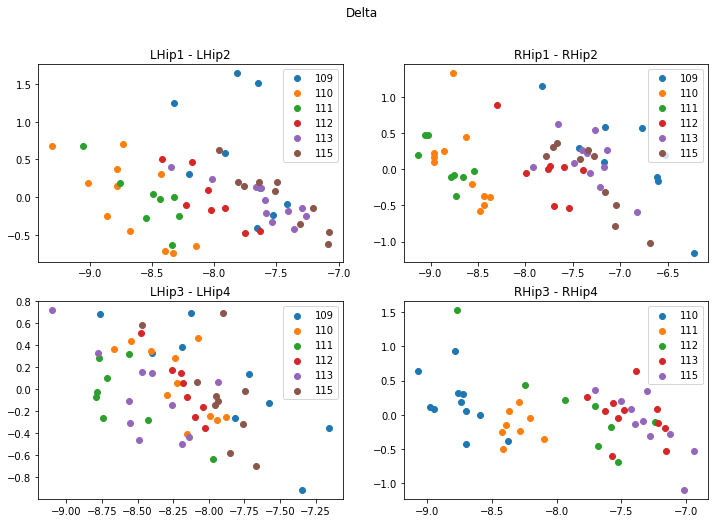

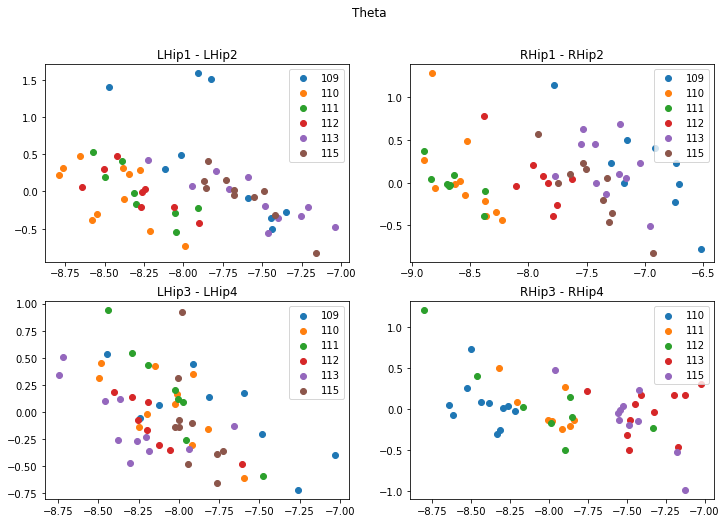

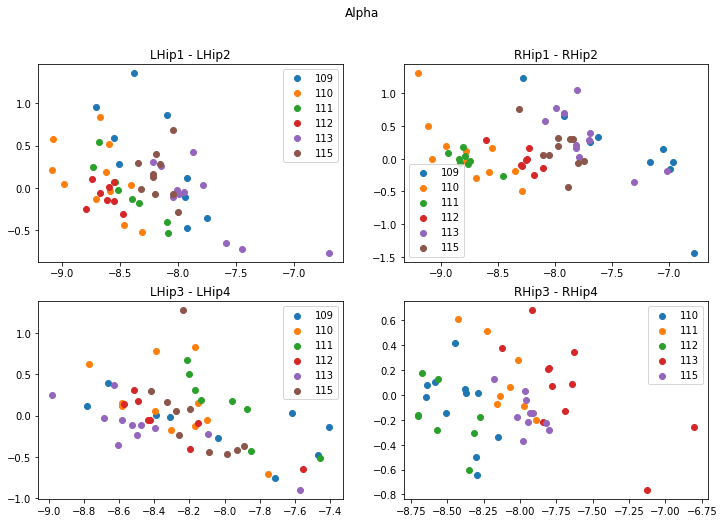

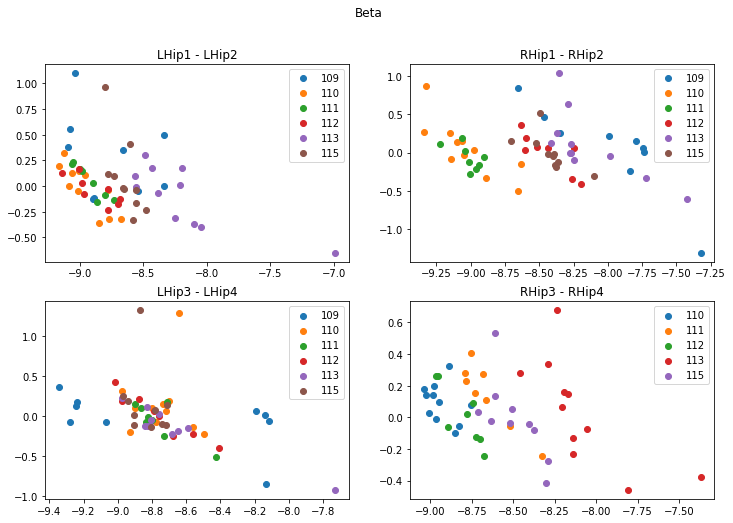

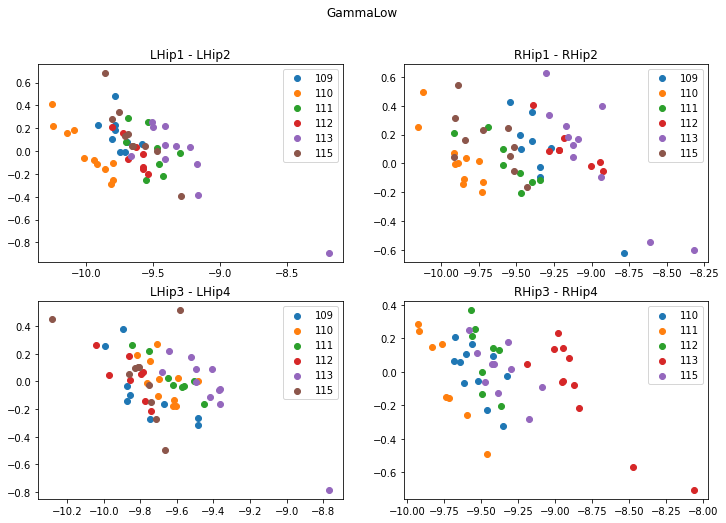

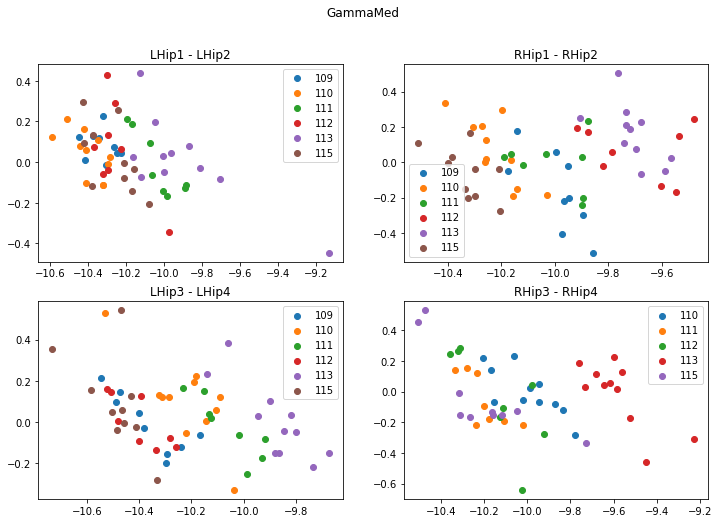

In [12]:
import statsmodels.formula.api as smf
from IPython.display import display

freqs = ['Delta', 'Theta', 'Alpha', 'Beta', 'GammaLow', 'GammaMed']
sham_stats = []
for freq in freqs:
    hip_chans = ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']
    fig, axs = plt.subplots(2, 2)
    fig.set_size_inches(12, 8)
    fig.suptitle(freq)
    for ch_num, chan in enumerate(hip_chans):
        power_for_chan = power_log_chg[(power_log_chg['Channel'] == chan)]
        ax = axs[ch_num % 2, ch_num // 2]
        for i, pt in enumerate(power_for_chan['ID'].unique()):
            power_for_pt = power_for_chan[power_for_chan['ID'] == pt]
            ax.scatter(np.log10(power_for_pt[freq+'_pre']), power_for_pt[freq+'_log_chg'], label=pt)
            ax.legend()
            ax.set_title(chan)
        model = smf.mixedlm(f'{freq}_log_chg ~ np.log10({freq}_pre)', power_for_chan, groups=power_for_chan['ID'])
        results = model.fit()
        # 0th value is for intercept, 1th is for $FREQ_pre
        print(f"{freq} {chan}: t = {results.tvalues[1]:.2f}, p = {results.pvalues[1]}")
        sham_stats.append({
            'freq': freq, 'chan': chan,
            't': results.tvalues[1], 'p': results.pvalues[1], 'coeff': results.params[1], 'int': results.params[0]})

RIP. We are 100% looking at regression to the mean. In these cases, there was no stimulation between pre and post, but we see the same pattern. I still think it's not absurd to imagine that my hypothesis is true, though, so maybe we can like subtract out the control from the stim?

In [13]:
df_stim = pd.DataFrame(stim_stats)
df_sham = pd.DataFrame(sham_stats)
df_both = df_sham.merge(df_stim, on=['freq', 'chan'], suffixes=['_sham', '_stim'])

In [14]:
df_both

freq           chan     t_sham        p_sham  coeff_sham   int_sham  \
0      Delta  LHip1 - LHip2  -5.280606  1.287576e-07   -0.927171  -7.377569   
1      Delta  LHip3 - LHip4  -6.309649  2.796688e-10   -0.819854  -6.738279   
2      Delta  RHip1 - RHip2  -5.968755  2.390707e-09   -0.938729  -7.286594   
3      Delta  RHip3 - RHip4  -4.908523  9.176480e-07   -0.997886  -7.922406   
4      Theta  LHip1 - LHip2  -6.361639  1.996115e-10   -1.062073  -8.447375   
5      Theta  LHip3 - LHip4  -6.008331  1.874433e-09   -0.793763  -6.398608   
6      Theta  RHip1 - RHip2  -6.191946  5.942600e-10   -0.994850  -7.713601   
7      Theta  RHip3 - RHip4  -2.847841  4.401686e-03   -0.638480  -5.019161   
8      Alpha  LHip1 - LHip2  -5.282836  1.271993e-07   -0.833417  -6.865645   
9      Alpha  LHip3 - LHip4  -5.305562  1.123262e-07   -0.707183  -5.819840   
10     Alpha  RHip1 - RHip2  -8.036720  9.227531e-16   -1.064984  -8.568981   
11     Alpha  RHip3 - RHip4  -4.430970  9.381017e-06   -0.722810  -5.918580   
12      Beta  LHip1 - LHip2  -4.181837  2.891633e-05   -0.554183  -4.790494   
13      Beta  LHip3 - LHip4  -3.858642  1.140186e-04   -0.555198  -4.845281   
14      Beta  RHip1 - RHip2  -8.284206  1.188994e-16   -1.070672  -9.086190   
15      Beta  RHip3 - RHip4  -5.602508  2.112726e-08   -0.846296  -7.221733   
16  GammaLow  LHip1 - LHip2  -9.074241  1.144721e-19   -0.856081  -8.215767   
17  GammaLow  LHip3 - LHip4  -5.846760  5.012396e-09   -0.843735  -8.174203   
18  GammaLow  RHip1 - RHip2 -10.264025  1.023496e-24   -0.968600  -9.066504   
19  GammaLow  RHip3 - RHip4  -7.518685  5.532995e-14   -0.874329  -8.213886   
20  GammaMed  LHip1 - LHip2  -4.386092  1.154052e-05   -0.559826  -5.673636   
21  GammaMed  LHip3 - LHip4  -6.908971  4.881831e-12   -1.007968 -10.290063   
22  GammaMed  RHip1 - RHip2  -2.784913  5.354214e-03   -0.567528  -5.662889   
23  GammaMed  RHip3 - RHip4  -6.574748  4.873562e-11   -1.005807 -10.111812   

      t_stim        p_stim  coeff_stim  int_stim  
0  -9.024115  1.811540e-19   -0.818034 -6.239166  
1  -9.376084  6.846847e-21   -0.900632 -6.841217  
2  -8.104266  5.306495e-16   -0.876164 -6.557689  
3  -8.250531  1.576929e-16   -0.864825 -6.602413  
4  -9.153668  5.503259e-20   -0.884853 -6.867720  
5  -8.931894  4.187754e-19   -0.888967 -6.936515  
6  -5.821038  5.848312e-09   -0.726646 -5.543415  
7  -6.713339  1.902198e-11   -0.783634 -5.977854  
8  -8.476128  2.328117e-17   -0.957459 -7.729475  
9  -7.467103  8.197991e-14   -0.781282 -6.353323  
10 -4.925736  8.404326e-07   -0.616904 -4.868276  
11 -6.598537  4.152344e-11   -0.794286 -6.317468  
12 -8.161787  3.301035e-16   -0.953812 -8.218217  
13 -8.184268  2.739627e-16   -0.883159 -7.664120  
14 -4.131527  3.603615e-05   -0.550780 -4.611012  
15 -3.165276  1.549361e-03   -0.533184 -4.486831  
16 -5.710900  1.123802e-08   -0.929723 -8.905319  
17 -7.653491  1.955954e-14   -1.027023 -9.866321  
18 -2.795130  5.187880e-03   -0.629712 -5.888299  
19 -1.120223  2.626189e-01   -0.316237 -2.907679  
20 -8.506874  1.786851e-17   -0.861432 -8.709288  
21 -8.234013  1.810442e-16   -0.978574 -9.933898  
22 -1.362953  1.728972e-01   -0.339668 -3.333271  
23 -3.130920  1.742593e-03   -0.637415 -6.361541

In [15]:
results.tvalues

Intercept                -6.570259
np.log10(GammaMed_pre)   -6.574748
Group Var                 1.211107
dtype: float64

the below is just a sanity check to make sure that mixed effects works the way I think it does (looks for patterns within groups rather than between groups)

In [16]:
df_sham[df_sham['freq'] == 'Alpha']

freq           chan         t             p     coeff       int
8   Alpha  LHip1 - LHip2 -5.282836  1.271993e-07 -0.833417 -6.865645
9   Alpha  LHip3 - LHip4 -5.305562  1.123262e-07 -0.707183 -5.819840
10  Alpha  RHip1 - RHip2 -8.036720  9.227531e-16 -1.064984 -8.568981
11  Alpha  RHip3 - RHip4 -4.430970  9.381017e-06 -0.722810 -5.918580

In [17]:
power_for_chan = power_log_chg[power_log_chg['Channel'] == 'RHip3 - RHip4']
smf.mixedlm('Alpha_log_chg ~ np.log10(Alpha_pre)', power_for_chan, groups=power_for_chan['ID']).fit().summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:             MixedLM  Dependent Variable:  Alpha_log_chg
No. Observations:  48       Method:              REML         
No. Groups:        5        Scale:               0.0527       
Min. group size:   8        Log-Likelihood:      -6.0932      
Max. group size:   11       Converged:           Yes          
Mean group size:   9.6                                        
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           -5.919    1.335 -4.432 0.000 -8.536 -3.301
np.log10(Alpha_pre) -0.723    0.163 -4.431 0.000 -1.043 -0.403
Group Var            0.115    0.426                           
==============================================================

"""

In [18]:
power_for_chan = power_log_chg[power_log_chg['Channel'] == 'RHip3 - RHip4']
smf.ols('Alpha_log_chg ~ np.log10(Alpha_pre)', power_for_chan).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Alpha_log_chg   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.141
Date:                Mon, 04 Jul 2022   Prob (F-statistic):              0.291
Time:                        11:15:55   Log-Likelihood:                -9.4446
No. Observations:                  48   AIC:                             22.89
Df Residuals:                      46   BIC:                             26.63
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.0189      0.914     -1.115      0.271      -2.859       0.821
np.log10(Alpha_pre)    -0.1202      0.113     -1.068      0.291      -0.347       0.106
==============================================================================
Omnibus:                        0.945   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.624   Jarque-Bera (JB):                0.404
Skew:                           0.199   Prob(JB):                        0.817
Kurtosis:                       3.209   Cond. No.                         173.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

temp

In [19]:
from sklearn.linear_model import LinearRegression

freqs_short = [
    '0.1-3.0',
    '4-7',
    '8-12',
    '13-30',
    '40-57',
    '67-80',
]

def do_stats(power_and_mem, xlabel, ylabel, xlog=False, ylog=False):
    model = LinearRegression()

    fig, axs = plt.subplots(2, 2)
    # fig.suptitle(f"{xlabel.replace('$FREQ', 'Power')} vs {ylabel.replace('$FREQ', 'Power')}")
    fig.suptitle('Strength of Correlation between Pre-stim and Post-Stim ECoG Power')
    fig.set_size_inches(16, 12)

    for i, chan in enumerate(hip_chans):
        corrs = []
        power_for_chan = power_and_mem[power_and_mem['Channel'] == chan]
        for freq in freqs:
            xfeature = xlabel.replace('$FREQ', freq) if '$FREQ' in xlabel else xlabel
            yfeature = ylabel.replace('$FREQ', freq) if '$FREQ' in ylabel else ylabel
            X = power_for_chan[[xfeature]]
            if xlog:
                X = np.log10(X)
            Y = power_for_chan.eval(yfeature)
            if ylog:
                Y = np.log10(Y)
            model.fit(X, Y)
            corrs.append(model.score(X, Y))
            # print(f"{chan}, {freq}: r^2 = {corrs[-1]}")

        if '$FREQ' not in ylabel:
            X = pd.get_dummies(power_for_chan['ID'])
            Y = power_for_chan.eval(ylabel)
            if ylog:
                Y = np.log10(Y)
            model.fit(X, Y)
            corrs.append(model.score(X, Y))
        # else:
        #     corrs.append(0)

        ind = np.arange(len(corrs))
        colors = ['tab:orange' for _ in corrs]
        # colors[-1] = 'tab:blue'
        axs[i//2, i%2].bar(ind, corrs, color=colors)
        axs[i//2, i%2].set_xticks(ind, labels=[*freqs_short]) # [*freqs_short, 'ID']
        axs[i//2, i%2].set_xlabel('Frequency Band (Hz)')
        axs[i//2, i%2].set_ylabel('$R^2$')
        axs[i//2, i%2].set_title(chan)
        axs[i//2, i%2].set_ylim(0, 1)

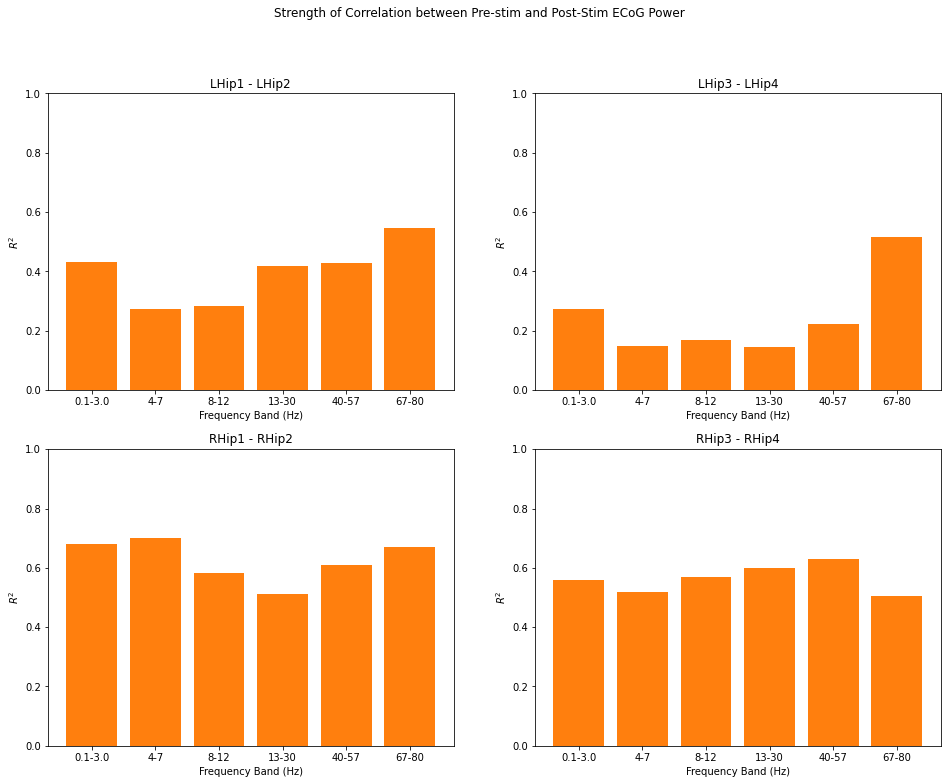

In [20]:
do_stats(power_log_chg, '$FREQ_pre', '$FREQ_post', xlog=True, ylog=True)